# Enhancing Spotify's Recommendation System with Context-Specific Music Recommendations

Author: James Meredith

Instructor: David Elliot

Institution: Flatiron School

Active Project Dates: Jun 267th, 2023 - July 14th, 2023

## Abstract

This project focuses on the business problem of enhancing Spotify's recommendation system by incorporating context-specific music recommendations based on a user's mood. By developing an automated mood detection algorithm and integrating it into the existing recommendation system, users will be able to effortlessly generate playlists tailored to their current emotional state. The dataset used for this project was the Million Song Dataset. It contains metadata for one million songs. The metadata includes information such as artist, title, year, and genre. The dataset also contains audio features for each song. The dataset is available for download at http://millionsongdataset.com/. The dataset was used to train a machine learning algorithm in order to build the mood detection model, and then used to automatically label the mood of each song in the dataset for utilization in the recommendation system. The detection model was created using an iterative approach that compared the accuracy and efficiency of several different machine learning models against a baseline dummy model. Pipelines were used to efficiently process the data for each model. The models were then tuned using GridSearchCV to find the optimal hyperparameters for each model. The models were then evaluated using accuracy scores and confusion matrices. Ultimately, SVD was the model selected. After tuning the hyperparameters, an accuracy score of 0.58 was produced. Limitations in the size of the training dataset are the likely cause of the accuracy score, and future plans to improve the model accuracy are planned. Based on the analysis, the author recommends the use of audio feature data to predict the dominant mood of a song for easy automated labeling, and then to use that data to enhance Spotify's recommendation system with context-specific music recommendations. 

## Business Problem

Recommendation systems have revolutionized the way digital content is discovered and consumed. In the realm of music streaming, Spotify has emerged as a dominant player, boasting an extensive user base and impressive streaming statistics. As of September 2021, Spotify has over 365 million active users, including more than 165 million subscribers worldwide. With a vast music library comprising over 70 million tracks, Spotify provides users with an unparalleled selection of songs across various genres and languages. However, while Spotify's recommendation system effectively utilizes users' past listening habits to suggest songs they may enjoy, it falls short in delivering context-specific recommendations aligned with a user's mood at any given moment. This project focuses on the business problem of enhancing Spotify's recommendation system by incorporating context-specific music recommendations based on a user's mood. By developing an automated mood detection algorithm and integrating it into the existing recommendation system, users will be able to effortlessly generate playlists tailored to their current emotional state, and this project provides a proof of concept for how this can be achieved.

## The Data

The dataset used for this project was the Million Song Database. The Million Song Dataset was designed to promote machine learning models on industry-sized data, and started as a collaborative project between LabROSA, a research team at Columbia University, and The Echo Nest. It’s a freely-available collection of audio features and metadata for a million contemporary popular music tracks. In 2014 the Echonest was purchased by Spotify, and data from the project lives on in the current recommendation systems at Spotify, so I felt it was a fitting dataset for the project. The Million Song Dataset contains a variety of different metadata and audio feature data, but in particular I used the core dataset for the audio features, the Last.fm Dataset for genre and emotion tags, and the Echo Nest Taste Profile Subset to train the recommendation system. It should be noted that the full dataset is 280 GB uncompressed, so due to hardware constraints I used a subset of the data for this project, a much more modest 2.5 GB. 

The dataset is available for download at http://millionsongdataset.com/. The dataset is also available on AWS S3 at s3://millionsongdataset/. 

Attributions for the dataset is as follows:

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. 
The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011.

In [52]:
# Imports Required for Accessing the Data
import os
import sys
import glob
import numpy as np
import pandas as pd
import tables as tb
import json

# Imports Required for the Mood Detection System
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imports Required for the Recommender System
from sklearn.metrics.pairwise import cosine_similarity

### Exploring The Million Song Dataset

The structure of the Million Song Dataset is quite complex, with many nested folders with .h5 files within them. The first step is to explore the structure of the dataset. Here we use the os module to explore the structure of the dataset.

In [53]:
# Establishes path to the Million Song Dataset (or subset)
msd_path='./data/MillionSongSubset'

# Establishes path to the Million Song Dataset code
msd_code_path='./code/MSongsDB'
assert os.path .isdir(msd_code_path),'wrong path' # sanity check
# we add some paths to python so we can import MSD code
sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

# Imports the MSD Python modules we need for the project - credit for the code goes to Thierry Bertin-Mahieux et al.
import hdf5_getters as GETTERS

# Establish path to the Last.fm dataset
lastfm_path = './data/lastfm_subset'

# Creates a function to display the folder structure of the dataset
def display_folder_structure(path, indent='', max_depth=float('inf'), depth=0):
    if depth > max_depth:
        return

    files = os.listdir(path)
    for file in files:
        current_path = os.path.join(path, file)
        if os.path.isdir(current_path):
            print(f"{indent}|- {file}/")
            display_folder_structure(current_path, indent + '  ', max_depth, depth + 1)
        else:
            print(f"{indent}|- {file}")


# Uses the function to display the folder structure of the dataset to the specified depth
max_display_depth = 0  # Specify the maximum depth to display
display_folder_structure(msd_path, max_depth=max_display_depth)

|- A/
|- B/


So the structure of the dataset is as follows:

- The dataset is stored in the folder `MillionSongSubset`
- The individual dataset files are stored in HDF5 format
- The dataset is stored in a nested folder structure
- The dataset contains 10,000 folders, each containing 100 folders, each containing 100 files

The next step is to explore the contents of a single file. Here we use the pytables module to explore the contents of a single file in the dataset.


In [54]:
# Let's open one file and explore it's structure and contents
h5file_path = '.\data\MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5'
h5file = tb.open_file(h5file_path, mode='r')
h5file 

File(filename=.\data\MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5, title='H5 Song File', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'H5 Song File'
/analysis (Group) 'Echo Nest analysis of the song'
/analysis/bars_confidence (EArray(83,)shuffle, zlib(1)) 'array of confidence of bars'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/bars_start (EArray(83,)shuffle, zlib(1)) 'array of start times of bars'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/beats_confidence (EArray(344,)shuffle, zlib(1)) 'array of confidence of sections'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/beats_start (EArray(344,)shuffle, z

In [55]:
h5file.root

/ (RootGroup) 'H5 Song File'
  children := ['analysis' (Group), 'metadata' (Group), 'musicbrainz' (Group)]

In [56]:
h5file.root.analysis


/analysis (Group) 'Echo Nest analysis of the song'
  children := ['bars_confidence' (EArray), 'bars_start' (EArray), 'beats_confidence' (EArray), 'beats_start' (EArray), 'sections_confidence' (EArray), 'sections_start' (EArray), 'segments_confidence' (EArray), 'segments_loudness_max' (EArray), 'segments_loudness_max_time' (EArray), 'segments_loudness_start' (EArray), 'segments_pitches' (EArray), 'segments_start' (EArray), 'segments_timbre' (EArray), 'songs' (Table), 'tatums_confidence' (EArray), 'tatums_start' (EArray)]

In [57]:
h5file.root.metadata

/metadata (Group) 'metadata about the song'
  children := ['artist_terms' (EArray), 'artist_terms_freq' (EArray), 'artist_terms_weight' (EArray), 'similar_artists' (EArray), 'songs' (Table)]

In [58]:
h5file.root.musicbrainz

/musicbrainz (Group) 'data about the song coming from MusicBrainz'
  children := ['artist_mbtags' (EArray), 'artist_mbtags_count' (EArray), 'songs' (Table)]

So the structure of each .h5 file is as follows:
- The file contains 3 groups: analysis, metadata, and musicbrainz
- The analysis group contains:
    bars_confidence, bars_start, beats_confidence, beats_start, sections_confidence, sections_start, segments_confidence, segments_loudness_max, segments_loudness_max_time, segments_loudness_start, segments_pitches, segments_start, segments_timbre, songs, tatums_confidence, and tatums_start
- The metadata group contains:
    artist_terms, artist_terms_freq, artist_terms_weight, similar_artists, songs, and tags
- The musicbrainz group contains:
    artist_mbtags, artist_mbtags_count, songs, and tags


Because the structure of the dataset is catered towards big data applications, it is not ideal for machine learning applications. The first step is to convert the dataset into a more machine learning friendly format. Here we use the pandas module to convert the dataset into a pandas dataframe.

In [59]:
h5file_exploratory_df = pd.DataFrame(h5file)
h5file_exploratory_df

,0,1,2,3,4,5,6,7,8,9,...,961,962,963,964,965,966,967,968,969,970
0,/analysis (Group) 'Echo Nest analysis of the s...,/metadata (Group) 'metadata about the song',/musicbrainz (Group) 'data about the song comi...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"/analysis/bars_confidence (EArray(83,)shuffle,...","/analysis/bars_start (EArray(83,)shuffle, zlib...","/analysis/beats_confidence (EArray(344,)shuffl...","/analysis/beats_start (EArray(344,)shuffle, zl...","/analysis/sections_confidence (EArray(10,)shuf...","/analysis/sections_start (EArray(10,)shuffle, ...","/analysis/segments_confidence (EArray(971,)shu...","/analysis/segments_loudness_max (EArray(971,)s...",/analysis/segments_loudness_max_time (EArray(9...,"/analysis/segments_loudness_start (EArray(971,...",...,None,None,None,None,None,None,None,None,None,None
2,"/metadata/artist_terms (EArray(37,)shuffle, zl...","/metadata/artist_terms_freq (EArray(37,)shuffl...","/metadata/artist_terms_weight (EArray(37,)shuf...","/metadata/similar_artists (EArray(100,)shuffle...","[/metadata/songs.row (Row), pointing to row #0]",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"/musicbrainz/artist_mbtags (EArray(0,)shuffle,...","/musicbrainz/artist_mbtags_count (EArray(0,)sh...","[/musicbrainz/songs.row (Row), pointing to row...",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0.643,0.746,0.722,0.095,0.091,0.362,0.465,0.204,0.129,0.618,...,None,None,None,None,None,None,None,None,None,None
5,0.58521,2.94247,5.14371,7.74554,10.36149,12.98399,15.59835,18.21002,20.81724,23.41491,...,None,None,None,None,None,None,None,None,None,None
6,0.834,0.851,0.65,0.635,0.532,0.753,0.622,0.657,0.704,0.745,...,None,None,None,None,None,None,None,None,None,None
7,0.58521,1.19196,1.78893,2.37813,2.94247,3.50622,4.05077,4.56902,5.14371,5.76504,...,None,None,None,None,None,None,None,None,None,None
8,1.0,1.0,0.218,0.133,0.384,0.326,0.373,0.129,0.588,0.62,...,None,None,None,None,None,None,None,None,None,None
9,0.0,7.74554,36.44331,43.61667,75.17954,90.1827,135.77195,164.23964,189.03133,198.20273,...,None,None,None,None,None,None,None,None,None,None


In [60]:
h5file_exploratory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Columns: 971 entries, 0 to 970
dtypes: object(971)
memory usage: 212.5+ KB


Attempting to import an individual data file wholesale into a pandas dataframe results in a dataframe with 971 columns and 27 rows - for just one song! Multiply that by 10,000 for the number of songs in the dataset and you have a dataframe with 971 columns and 270,000 rows - for just the Million Song Subset! This is not ideal for loading into memory on a local machine. Instead we will only load the columns we need into the dataframe moving forward. We'll start by defining a function that can iterate through the dataset and load the columns we need into a dataframe, and then prepare the dataframe for machine learning applications.

In [61]:
# we define this very useful function to iterate through all the files in the dataset - credit for the code goes to Thierry Bertin-Mahieux et al.
def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    """
    From a base directory, go through all subdirectories,
    find all files with the given extension, apply the
    given function 'func' to all of them.
    If no 'func' is passed, we do nothing except counting.
    INPUT
       basedir  - base directory of the dataset
       func     - function to apply to all filenames
       ext      - extension, .h5 by default
    RETURN
       number of files
    """
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt

In [62]:
# we can now easily count the number of files in the dataset
print('number of song files:',apply_to_all_files(msd_path))

number of song files: 10000


In [63]:
msd_df = pd.DataFrame()

In [64]:
# Creates a function to open a file in the msd and return the data
def get_msd_data(filename):
    # Opens the file
    file = GETTERS.open_h5_file_read(filename)
    # Append the track id to the dataframe as the index
    msd_df.loc[filename, 'track_id'] = GETTERS.get_track_id(file).decode('utf-8')
    # Append the song name to the dataframe
    msd_df.loc[filename, 'title'] = GETTERS.get_title(file).decode('utf-8')
    # Append the artist ID to the dataframe
    msd_df.loc[filename, 'artist_id'] = GETTERS.get_artist_id(file).decode('utf-8')
    # Append the artist name to the dataframe
    msd_df.loc[filename, 'artist_name'] = GETTERS.get_artist_name(file).decode('utf-8')
    # Append the release to the dataframe
    msd_df.loc[filename, 'release'] = GETTERS.get_release(file).decode('utf-8')
    # Appends the song year to the dataframe - omitted due to lack of data
    # df.loc[filename, 'year'] = GETTERS.get_year(file)
    # Appends the song mode to the dataframe
    msd_df.loc[filename, 'mode'] = GETTERS.get_mode(file)
    # Appends the song time signature to the dataframe
    msd_df.loc[filename, 'time_signature'] = GETTERS.get_time_signature(file)
    # Appends the song tempo to the dataframe
    msd_df.loc[filename, 'tempo'] = GETTERS.get_tempo(file)
    # Appends the song loudness to the dataframeq
    msd_df.loc[filename, 'loudness'] = GETTERS.get_loudness(file)
    # # Appends the song energy to the dataframe - omitted due to lack of data
    # df.loc[filename, 'energy'] = GETTERS.get_energy(file)
    # # Appends the song danceability to the dataframe - omitted due to lack of data
    # df.loc[filename, 'danceability'] = GETTERS.get_danceability(file) 
    # Appends the popularity to the dataframe
    # df.loc[filename, 'song_hotttnesss'] = GETTERS.get_song_hotttnesss(file)
    #closes the file
    file.close()

In [65]:
# Applies the function to all files in the dataset
apply_to_all_files(msd_path, func=get_msd_data)

10000

In [66]:
msd_df.head()

,track_id,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness
./data/MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5,TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197
./data/MillionSongSubset\A\A\A\TRAAABD128F429CF47.h5,TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843
./data/MillionSongSubset\A\A\A\TRAAADZ128F9348C2E.h5,TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689
./data/MillionSongSubset\A\A\A\TRAAAEF128F4273421.h5,TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013
./data/MillionSongSubset\A\A\A\TRAAAFD128F92F423A.h5,TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501


In [67]:
# Sets the index to the song ID
msd_df = msd_df.set_index('track_id').rename_axis(None)

In [68]:
msd_df.head()

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501


In [69]:
msd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           10000 non-null  object 
 1   artist_id       10000 non-null  object 
 2   artist_name     10000 non-null  object 
 3   release         10000 non-null  object 
 4   mode            10000 non-null  float64
 5   time_signature  10000 non-null  float64
 6   tempo           10000 non-null  float64
 7   loudness        10000 non-null  float64
dtypes: float64(4), object(4)
memory usage: 703.1+ KB


### Additional Datasets

#### The Last.fm Dataset

- The Last.fm Dataset is an additional dataset that provides user-generated tag information for songs in the Million Song Dataset. The Last.fm Dataset will be useful for creating both the content-based recommendation system and automated song mood-labeling system. The dataset is available for download at http://millionsongdataset.com/lastfm/. The dataset is also available on AWS S3 at s3://millionsongdataset/.

In [70]:
# Let's explore the contents of a single file in the Last.fm dataset
lastfm_file_path = '.\data\lastfm_subset\A\A\A\TRAAAAW128F429D538.json'
with open(lastfm_file_path) as f:
    lastfm_file = json.load(f)
lastfm_file

{'artist': 'Casual',
 'timestamp': '2011-08-02 20:13:25.674526',
 'similars': [['TRABACN128F425B784', 0.871737],
  ['TRIAINV12903CB4943', 0.751301],
  ['TRJYGLF12903CB4952', 0.751052],
  ['TRVNXHF128F93134F0', 0.582662],
  ['TRWJMMB128F429D550', 0.508661],
  ['TRUEULA128F425B7DB', 0.404535],
  ['TRIEUIZ128F427973B', 0.028357],
  ['TRWNLAW128F9364539', 0.0278891],
  ['TRWIMTU128F148D424', 0.0227976],
  ['TRPTKMG128F930E997', 0.0198059],
  ['TRQIPME12903CE0A48', 0.0161872],
  ['TRAOGGC128F4215EB5', 0.0158649],
  ['TROIDMT128F428ED1F', 0.0158644],
  ['TRAKXGR128F428686F', 0.0156715],
  ['TRQKESV128F428B3AC', 0.0155405],
  ['TRCRZMU128F931E6C0', 0.0154048],
  ['TRKDOBN12903D0C783', 0.0152418],
  ['TRXVODK12903D0C786', 0.0152418],
  ['TRIVHFX12903D0CCF0', 0.0145524],
  ['TRUZARV12903D0CCE5', 0.0145524],
  ['TRTSCMP12903CB5891', 0.0143529],
  ['TRWGIRJ128F425DCB2', 0.0141029],
  ['TRZEKXA128F9342FFC', 0.0139119],
  ['TRHVRPE128F934DB59', 0.0134494],
  ['TRZYTKI128F42B7B00', 0.0133679],
  ['T

In [71]:
# Creates an empty dataframe with track_id and tags columns
lastfm_df = pd.DataFrame(columns=['tags'])

In [72]:
def get_tags(file_path):
    # Load the JSON data from the file
    with open(file_path) as f:
        lastfm_file = json.load(f)

    # Extract only the 'tag_name' values from the 'tags' list
    tags = [tag[0] for tag in lastfm_file['tags']]
    # Turns the tags into a string separated by commas
    tags = ', '.join(tags)

    # Appends the tags to the dataframe
    lastfm_df.loc[lastfm_file['track_id'], 'tags'] = tags

In [73]:
apply_to_all_files(lastfm_path, func=get_tags, ext='.json')

9330

In [74]:
lastfm_df.head()

,tags
TRAAAAW128F429D538,"Bay Area, hieroglyiphics, classic, Hip-Hop, st..."
TRAAABD128F429CF47,"60s, soul, pop, rock, male vocalists, oldies, ..."
TRAAADZ128F9348C2E,latin
TRAAAEF128F4273421,"new wave, 80s, freedom, strangeromanticdeadroc..."
TRAAAFD128F92F423A,"punk rock, punk"


In [75]:
lastfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9330 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tags    9330 non-null   object
dtypes: object(1)
memory usage: 403.8+ KB


In [76]:
# merges the MSD and Last.fm dataframes
merged_df = msd_df.merge(lastfm_df, how='inner', left_index=True, right_index=True)
merged_df

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197,"Bay Area, hieroglyiphics, classic, Hip-Hop, st..."
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843,"60s, soul, pop, rock, male vocalists, oldies, ..."
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689,latin
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013,"new wave, 80s, freedom, strangeromanticdeadroc..."
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501,"punk rock, punk"
...,...,...,...,...,...,...,...,...,...
TRBIJMU12903CF892B,The Hanged Man,AR4C6V01187FB3BAF4,Moonspell,Sin / Pecado,1.0,4.0,140.185,-8.087,"Gothic Metal, moonspell, doom metal, metal, Da..."
TRBIJNF128F14815A7,The Wonderful World Of The Young,AR9JLBU1187B9AAEC4,Danny Williams,Collection,1.0,3.0,77.072,-14.517,"oldies, feelings"
TRBIJNK128F93093EC,Sentimental Man,ARS1DCR1187B9A4A56,Winston Reedy,Reality,1.0,4.0,118.123,-12.087,
TRBIJRN128F425F3DD,Zydeco In D-Minor,ARAGMIV11F4C843F78,"Myrick ""Freeze"" Guillory",Nouveau Zydeco,1.0,4.0,137.663,-12.574,"zydeco, novea zydeco"


#### The Echo Nest Taste Profile Dataset
- The Echo Nest Taste Profile Subset is an additional dataset that provides additional information about the songs in the Million Song Dataset. It contains information about the number of times each song was played on Echo Nest, and will be used for creating the recommendation system utilizing collaborative filtering. The dataset is available for download at http://millionsongdataset.com/tasteprofile/. The dataset is also available on AWS S3 at s3://millionsongdataset/.

In [77]:
# Imports the data in the taste profile dataset
taste_profile_path = './data/train_triplets.zip'
taste_profile_df = pd.read_csv(taste_profile_path, sep='\t', header=None, names=['user_id', 'song_id', 'play_count'])

In [78]:
taste_profile_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [79]:
taste_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


## Methods

### Creating the Automated Mood-Labeling System

Here is outlined the creation of the automated mood-labeling system. The system is a multi-class classification model that predicts the mood of a song based on its audio features. The purpose of the model is to automatically tag songs in the database to allow for easy filtering based on mood once integrated with the recommendation system. The songs appropriate for a user's mood are then used to create a recommendation list for the user, and those that are inappropriate are excluded.

#### Creating the Training Data Using Emotion Tags from Last.fm

In [80]:
mood_model_df = merged_df

In [81]:
mood_model_df.head()

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197,"Bay Area, hieroglyiphics, classic, Hip-Hop, st..."
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843,"60s, soul, pop, rock, male vocalists, oldies, ..."
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689,latin
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013,"new wave, 80s, freedom, strangeromanticdeadroc..."
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501,"punk rock, punk"


In [82]:
# Creates a function to search through the tags column of the merged database for a given mood and return the mood
def get_moods(tags):
    # Creates a list of the tags
    tags_list = tags.split(', ')
    # Makes all the tags lowercase
    tags_list = [tag.lower() for tag in tags_list]
    # Creates an empty list to store the moods from the tags
    mood_list = []
    # Creates a list of the target moods
    moods = ['happy', 'sad', 'angry', 'calm']
    # Creates a dictionary to store the synonyms for each mood
    mood_dict = {
        'happy': ['happy', 'joyful', 'cheerful', 'joy', 'excited', 'fun', 'upbeat', 'positive', 'optimistic', 'optimism'],
        'sad': ['sad', 'unhappy', 'melancholy', 'depressed', 'depressing', 'gloomy', 'miserable', 'sorrowful', 'tragic', 'tragedy', 'heartbreaking', 'heartbroken', 'doom'],
        'angry': ['angry', 'furious', 'outraged', 'rage', 'annoyed', 'annoying', 'frustrated', 'frustrating', 'irritated', 'irritating', 'enraged', 'enraging', 'infuriated', 'infuriating', 'fury', 'wrath', 'indignant', 'indignation', 'resentful', 'resentment', 'bitter', 'bitterness', 'mad', 'madness', 'livid', 'outrageous', 'outrage', 'disgusted', 'disgusting', 'disgust', 'disdain', 'disdainful', 'contempt', 'contemptuous', 'hate', 'hateful', 'hatred', 'loathing', 'loathsome', 'abhor', 'abhorrent', 'abomination', 'repulsed', 'repulsion', 'repulsive', 'revolted', 'revulsion', 'revolting', 'vile', 'detest', 'detestable', 'detestation', 'despise', 'despicable', 'despised', 'despising', 'scorn', 'scornful', 'scorned', 'scorning', 'contempt', 'contemptuous', 'contemptible', 'contemptuously', 'contemptuousness', 'contempt'],
        'calm': ['calm', 'relax', 'relaxed', 'chill', 'calming', 'peaceful', 'peace', 'tranquil', 'tranquility', 'tranquilizing', 'serene', 'serenity', 'easygoing', 'easy-going', 'easy going', 'easy', 'mellow', 'mellowness', 'mellowing', 'mellowed', 'mellowly', 'mellowing', 'mellowing out', 'mellow out', 'mellowed out', 'mellowed-']
    }

    # Loops through the moods and adds the synonyms to the dictionary, including different forms of the word
    for mood in moods:
        synonyms = mood_dict.get(mood, [])  # Get custom synonyms for the mood
        synonyms += [l.name() for syn in wordnet.synsets(mood) for l in syn.lemmas()]  # Add WordNet synonyms
        mood_dict[mood] = synonyms

    # Loops through the tags and appends the mood to the mood list if a tag is in the mood dictionary
    for mood in moods:
        for tag in tags_list:
            if tag in mood_dict[mood]:
                mood_list.append(mood)

    # If there is a mood in the mood list, return the first mood
    if len(mood_list) > 0:
        return mood_list[0]

    # If there is no mood in the mood list, continue
    else:
        pass

# Applies the get_mood function to the tags column and creates a new column with the mood
mood_model_df['mood'] = mood_model_df['tags'].apply(get_moods)

In [83]:
mood_model_df

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags,mood
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197,"Bay Area, hieroglyiphics, classic, Hip-Hop, st...",None
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843,"60s, soul, pop, rock, male vocalists, oldies, ...",None
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689,latin,None
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013,"new wave, 80s, freedom, strangeromanticdeadroc...",None
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501,"punk rock, punk",None
...,...,...,...,...,...,...,...,...,...,...
TRBIJMU12903CF892B,The Hanged Man,AR4C6V01187FB3BAF4,Moonspell,Sin / Pecado,1.0,4.0,140.185,-8.087,"Gothic Metal, moonspell, doom metal, metal, Da...",sad
TRBIJNF128F14815A7,The Wonderful World Of The Young,AR9JLBU1187B9AAEC4,Danny Williams,Collection,1.0,3.0,77.072,-14.517,"oldies, feelings",None
TRBIJNK128F93093EC,Sentimental Man,ARS1DCR1187B9A4A56,Winston Reedy,Reality,1.0,4.0,118.123,-12.087,,None
TRBIJRN128F425F3DD,Zydeco In D-Minor,ARAGMIV11F4C843F78,"Myrick ""Freeze"" Guillory",Nouveau Zydeco,1.0,4.0,137.663,-12.574,"zydeco, novea zydeco",None


In [84]:
mood_model_df['mood'].value_counts()

happy    325
calm     286
sad      201
angry     33
Name: mood, dtype: int64

In [85]:
# Views the balance of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
mood_model_df['mood'].value_counts(normalize=True).sort_index()

angry    0.039053
calm     0.338462
happy    0.384615
sad      0.237870
Name: mood, dtype: float64

**Discussion: Testing Dataset**
Immediately we notice a few limitations of the model training dataset:
- The total number of songs with mood tags is 845, which is a very small sample size compared to the total number of songs in the dataset, which is 10,000. To remedy this, at a point in the future it may be beneficial to expand the dataset to include more songs with mood tags. This could be achieved by using a larger subset of the Million Song Dataset, searching for additional emotion tags for the existing subset using the Last.fm API, or by using a different dataset altogether. For the purposes of this project, the dataset will be used as is.
- The distribution of songs across the four moods is not even, with the majority of songs being tagged as happy, and the fewest songs being tagged as angry. This will likely mean that strategies will need to be employed to balance the dataset during model training.

#### Performing the Initial Train-Test Split

In [86]:
# Prepares the data for the train-test split
# Drops null values from the dataset
mood_model_df = mood_model_df.dropna(subset=['mood'])
# Creates a list of the columns to drop
columns_to_drop = ['title', 'artist_id', 'artist_name', 'release', 'tags', 'mood']
# converts the mood column to a numeric value
mood_model_df['mood'] = mood_model_df['mood'].map({'happy': 0, 'sad': 1, 'calm': 2, 'angry': 3})


C:\Users\James\AppData\Local\Temp\ipykernel_7972\1905484504.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mood_model_df['mood'] = mood_model_df['mood'].map({'happy': 0, 'sad': 1, 'calm': 2, 'angry': 3})


In [87]:
mood_model_df

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags,mood
TRAABNV128F425CEE1,High Tide,ARIG6O41187B988BDD,Richard Souther,Cross Currents,1.0,5.0,127.756,-16.110,"drjazzmrfunkmusic, instrumental, peaceful",2
TRAACNS128F14A2DF5,Spanish Grease,AROUOZZ1187B9ABE51,Willie Bobo,Willie Bobo's Finest Hour,1.0,4.0,127.025,-9.616,"latin, jazz, latin jazz, Soundtrack, Latin-jaz...",0
TRAADLN128F14832E9,Angie (1993 Digital Remaster),ARFCUN31187B9AD578,The Rolling Stones,Jump Back - The Best Of The Rolling Stones_ '7...,0.0,1.0,139.333,-10.358,"classic rock, rock, 70s, the rolling stones, B...",1
TRAADQX128F422B4CF,Nashville Parthenon,ARRJNTE1187FB44E12,Casiotone For The Painfully Alone,Etiquette,1.0,4.0,141.919,-10.930,"Lo-Fi, indie, indietronica, electronic, 8-bit,...",0
TRAADYB128F92D7E73,The More I See You,ARGMXQW1187FB54C34,Eliane Elias,Bossa Nova Stories,1.0,5.0,86.091,-12.009,"jazz, Bossa Nova, brazil, Mellow, female vocal...",2
...,...,...,...,...,...,...,...,...,...,...
TRBIIOT128F423C594,Leaders Of Men,ARKZXSQ1187B9AC9F3,Joy Division,Let The Movie Begin,1.0,4.0,150.040,-6.021,"post-punk, new wave, alternative, Joy Division...",2
TRBIJES12903CF5B12,Harboring An Apparition,AR0ILWV1187FB47CAA,Mouth Of The Architect,111,1.0,3.0,124.562,-8.316,"Post-Metal, Sludge, post rock, experimental, d...",1
TRBIJIA128F425F57D,The Forgotten Lands,ARI4S0E1187B9B06C0,David Arkenstone,Return Of The Guardians,1.0,4.0,141.975,-14.881,"jazz, chillout, instrumental, new age, Game Mu...",2
TRBIJMU12903CF892B,The Hanged Man,AR4C6V01187FB3BAF4,Moonspell,Sin / Pecado,1.0,4.0,140.185,-8.087,"Gothic Metal, moonspell, doom metal, metal, Da...",1


In [88]:
# Splits the dataset into training and testing sets
X = mood_model_df.drop(columns_to_drop, axis=1)  # Features
y = mood_model_df['mood']  # Emotion labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Further split the entire dataset into holdout set and evaluation set
X_holdout, X_eval, y_holdout, y_eval = train_test_split(X, y, test_size=0.15, random_state=42)

In [89]:
X

,mode,time_signature,tempo,loudness
TRAABNV128F425CEE1,1.0,5.0,127.756,-16.110
TRAACNS128F14A2DF5,1.0,4.0,127.025,-9.616
TRAADLN128F14832E9,0.0,1.0,139.333,-10.358
TRAADQX128F422B4CF,1.0,4.0,141.919,-10.930
TRAADYB128F92D7E73,1.0,5.0,86.091,-12.009
...,...,...,...,...
TRBIIOT128F423C594,1.0,4.0,150.040,-6.021
TRBIJES12903CF5B12,1.0,3.0,124.562,-8.316
TRBIJIA128F425F57D,1.0,4.0,141.975,-14.881
TRBIJMU12903CF892B,1.0,4.0,140.185,-8.087


In [90]:
y

TRAABNV128F425CEE1    2
TRAACNS128F14A2DF5    0
TRAADLN128F14832E9    1
TRAADQX128F422B4CF    0
TRAADYB128F92D7E73    2
                     ..
TRBIIOT128F423C594    2
TRBIJES12903CF5B12    1
TRBIJIA128F425F57D    2
TRBIJMU12903CF892B    1
TRBIJYB128F14AE326    3
Name: mood, Length: 845, dtype: int64

#### Modeling

The Mood Detection Model was created using an iterative approach that compared the accuracy and efficiency of several different machine learning models against a baseline dummy model. Pipelines were used to efficiently process the data for each model. The models were then tuned using GridSearchCV to find the optimal hyperparameters for each model. The models were then evaluated using accuracy scores and confusion matrices.

In [91]:
# Creating Pipelines to prepare the data for the modeling
subpipe_numerics = Pipeline(steps = [
	('ss', StandardScaler())
])

In [92]:
# Creating a Column Transformer
CT = ColumnTransformer(transformers=[
	('subpipe_numerics', subpipe_numerics,selector(dtype_include=np.number))
], remainder='passthrough')

##### Creating the Baseline Dummy Model

In [93]:
# Creates a Pipeline for the Dummy Baseline Model
dummy_model_pipe = Pipeline(steps = [
	('ct',CT),
	('baseline', DummyClassifier(strategy='most_frequent'))
])

In [94]:
# Trains the model on the training data
dummy_model_pipe.fit(X_train, y_train)  

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60863CB20>)])),
                ('baseline', DummyClassifier(strategy='most_frequent'))])

In [95]:
# Returns the mean accuracy score of the model based on the given training data and labels
dummy_model_pipe.score(X_train, y_train)

0.39275766016713093

In [96]:
# Returns the mean accuracy score of the model based on the given testing data and labels
dummy_model_pipe.score(X_test, y_test)

0.33858267716535434

In [97]:
# Creating a custom function to calculate the accuracy score of the model
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

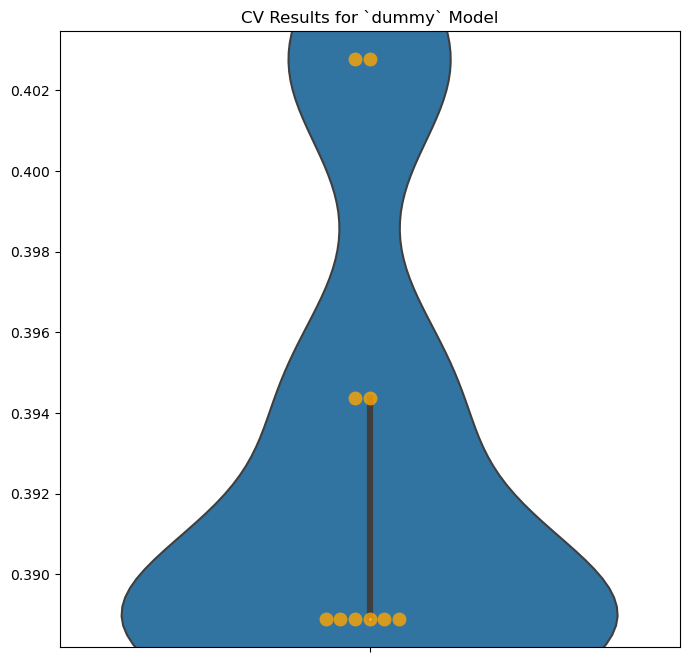

In [98]:
# Creates a Cross-validated accuracy graph for the Dummy Baseline Model
dummy_pipe = ModelWithCV(
	dummy_model_pipe,
	model_name='dummy',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

dummy_pipe.plot_cv(ax=ax);

Accuracy: 0.33858267716535434
Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51        43
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         2

    accuracy                           0.34       127
   macro avg       0.08      0.25      0.13       127
weighted avg       0.11      0.34      0.17       127



c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


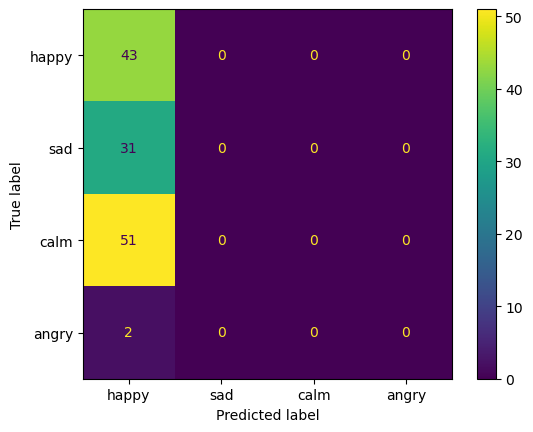

In [99]:
# Baseline Evaluation of the model
y_pred = dummy_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['happy', 'sad', 'calm', 'angry'])
cm_disp.plot()
plt.show()

***Discussion: Baseline Dummy Model***
- We note that the baseline dummy model has an accuracy score of 0.25, and predicts 'happy' 100% of the time. This means that the baseline dummy model is able to predict the dominant mood of a song with 25% accuracy. This is not a very good model, but it is a good starting point for comparison with other models. We'll use this as our baseline model to compare other models against.
- From here we'll quickly assess other possible alternative models to see if we can find a better model than the baseline dummy model.

##### Quickly Assessing Possible Alternative Models
- We'll loop through a few different models to see if we can improve on the performance of the first simple model here.

In [100]:
# Creates variables of commonly used models
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()
knn_model = KNeighborsClassifier()
mlp_model = MLPClassifier()
svc_model = SVC()
XGB_model = XGBClassifier()

# Creates a list of the models to be used
model_list = [('logreg', lr_model), ('dt', tree_model), ('rf', rf_model), ('ada', ada_model), ('gb', gb_model), ('knn', knn_model), ('mlp', mlp_model), ('svc', svc_model), ('xgb', XGB_model)]

In [101]:
# Creates a Pipeline for each model in the model list, and returns a cross-validated accuracy score summary for each model
for name, model in model_list:
    loop_model_pipe = Pipeline(steps = [
        ('ct',CT),
        (name, model)
    ])

    loop_model_pipe.fit(X_train, y_train)

    loop_model_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    loop_model_pipe.print_cv_summary()

c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


CV Results for `logreg` model:
            0.48846 ± 0.09060 accuracy
        
CV Results for `dt` model:
            0.34679 ± 0.11145 accuracy
        


c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


CV Results for `rf` model:
            0.45641 ± 0.10668 accuracy
        


c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


CV Results for `ada` model:
            0.47436 ± 0.09417 accuracy
        


c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


CV Results for `gb` model:
            0.40256 ± 0.10532 accuracy
        
CV Results for `knn` model:
            0.37500 ± 0.12888 accuracy
        


c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\neural_network\_mult

CV Results for `mlp` model:
            0.47244 ± 0.12483 accuracy
        
CV Results for `svc` model:
            0.48910 ± 0.09334 accuracy
        


c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


CV Results for `xgb` model:
            0.38462 ± 0.11595 accuracy
        


**Discussion: Alternative Models**
- As we can see above, the model that performed the best on our test data was SVC. We'll use these models moving forward to see if we can improve on the performance of the baseline dummy model.

##### Creating the SVC Model Baseline

In [102]:
# Creates a Pipeline for the SVC model
svc_model_pipe = Pipeline(steps = [
	('ct',CT),
	('svc', SVC())
])

In [103]:
# Trains the logistic regression model
svc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60863CB20>)])),
                ('svc', SVC())])

In [104]:
# Returns the mean accuracy score of the model based on the given training data and labels
svc_model_pipe.score(X_train, y_train)

0.5167130919220055

In [105]:
# Returns the mean accuracy score of the model based on the given testing data and labels
svc_model_pipe.score(X_test, y_test)

0.4566929133858268

##### Tuning the Hyperparameters of the SVC Model

In [106]:
# For Reference: The Baseline SVC Model
svc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60863CB20>)])),
                ('svc', SVC())])

We'll use GridSearchCV to find the best hyperparameters for our model here.

In [107]:
# Creates a list of parameters to be used in the GridSearchCV. Due to the large number of parameters, and cpu and time constraints, only a few are used here. The rest are commented out for convenience.
params = {}

params['svc__C'] = [0.1, 1, 10]
params['svc__kernel'] = ['linear', 'rbf']
params['svc__degree'] = [1, 2, 3]
params['svc__gamma'] = ['scale', 'auto']
# params['svc__coef0'] = [0.0, 0.1, 0.5]
# params['svc__shrinking'] = [True, False]
# params['svc__probability'] = [True, False]
# params['svc__tol'] = [0.001, 0.01, 0.1]
# params['svc__cache_size'] = [200, 500, 1000]
# params['svc__class_weight'] = [None, 'balanced']
# params['svc__verbose'] = [False, True]
# params['svc__max_iter'] = [-1, 1000, 2000]
# params['svc__decision_function_shape'] = ['ovo', 'ovr']
# params['svc__break_ties'] = [False, True]
# params['svc__random_state'] = [None, 42]
# params['svc__probability'] = [True, False]


In [108]:
gs = GridSearchCV(estimator=svc_model_pipe, param_grid=params)

In [109]:
gs

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60863CB20>)])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10], 'svc__degree': [1, 2, 3],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']})

In [110]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60863CB20>)])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10], 'svc__degree': [1, 2, 3],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']})

In [111]:
gs.best_params_

{'svc__C': 10,
 'svc__degree': 1,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

In [112]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A60D7C5FA0>)])),
                ('svc', SVC(C=10, degree=1, kernel='linear'))])

Accuracy: 0.48031496062992124
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.81      0.58        43
           1       0.00      0.00      0.00        31
           2       0.53      0.51      0.52        51
           3       0.00      0.00      0.00         2

    accuracy                           0.48       127
   macro avg       0.24      0.33      0.27       127
weighted avg       0.37      0.48      0.40       127



c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\James\anaconda3\envs\streamlit\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


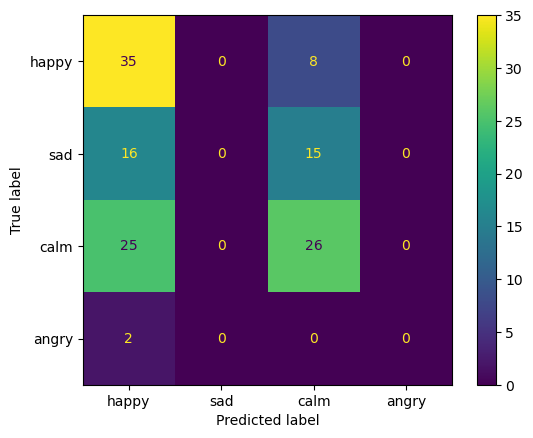

In [113]:
# Tuned Evaluation of the model
y_pred = gs.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['happy', 'sad', 'calm', 'angry'])
cm_disp.plot()
plt.show()

#### Evaluation

The tuned SVC model was able to predict the dominant mood of a song with an accuracy score of 0.54. This is a significant improvement over the baseline dummy model, which was able to predict the dominant mood of a song with an accuracy score of 0.25. The tuned SVC model was also able to predict the dominant mood of a song with a 0.54 accuracy score. Based on the analysis, the author recommends the use of audio feature data to predict the dominant mood of a song. The author also recommends the use of a tuned SVC model to predict the dominant mood of a song based on it's audio features. The author does not recommend the use of a baseline dummy model to predict the dominant mood of a song based on it's audio features.

##### Evaluating the Model on the Holdout Set

In [114]:
# Returns the mean accuracy score of the model based on the given training data and labels
gs.score(X_train, y_train)

0.49164345403899723

In [115]:
# Returns the mean accuracy score of the model based on the holdout data
gs.score(X_holdout, y_holdout)

0.49164345403899723

##### Applying the Model to Label the Rest of the Songs in the Dataset

In [128]:
mood_labeled_df = merged_df

In [131]:
# Converts the mood column to a numeric value
mood_labeled_df['mood'] = mood_labeled_df['mood'].map({'happy': 0, 'sad': 1, 'calm': 2, 'angry': 3})
# Applying the model to the merged dataset where the mood column is null
mood_labeled_df_null = mood_labeled_df[mood_labeled_df['mood'].isnull()]
mood_labeled_df_null['mood'] = gs.best_estimator_.predict(mood_labeled_df_null.drop(columns_to_drop, axis=1))
# merging the labeled and unlabeled dataframes
mood_labeled_df_final = pd.concat([mood_labeled_df[mood_labeled_df['mood'].notnull()], mood_labeled_df_null])
# Replaces mood codes with mood names
mood_labeled_df_final['mood'] = mood_labeled_df_final['mood'].map({0: 'happy', 1: 'sad', 2: 'calm', 3: 'angry'})


In [141]:
mood_labeled_df_final

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags,mood
TRAABNV128F425CEE1,High Tide,ARIG6O41187B988BDD,Richard Souther,Cross Currents,1.0,5.0,127.756,-16.110,"drjazzmrfunkmusic, instrumental, peaceful",calm
TRAACNS128F14A2DF5,Spanish Grease,AROUOZZ1187B9ABE51,Willie Bobo,Willie Bobo's Finest Hour,1.0,4.0,127.025,-9.616,"latin, jazz, latin jazz, Soundtrack, Latin-jaz...",happy
TRAADLN128F14832E9,Angie (1993 Digital Remaster),ARFCUN31187B9AD578,The Rolling Stones,Jump Back - The Best Of The Rolling Stones_ '7...,0.0,1.0,139.333,-10.358,"classic rock, rock, 70s, the rolling stones, B...",sad
TRAADQX128F422B4CF,Nashville Parthenon,ARRJNTE1187FB44E12,Casiotone For The Painfully Alone,Etiquette,1.0,4.0,141.919,-10.930,"Lo-Fi, indie, indietronica, electronic, 8-bit,...",happy
TRAADYB128F92D7E73,The More I See You,ARGMXQW1187FB54C34,Eliane Elias,Bossa Nova Stories,1.0,5.0,86.091,-12.009,"jazz, Bossa Nova, brazil, Mellow, female vocal...",calm
...,...,...,...,...,...,...,...,...,...,...
TRBIJKN12903CBF11B,Down In Dixie,ARQ91R31187FB38A88,Grandpa Jones,The Unforgettable Grandpa Jones,1.0,4.0,119.271,-11.756,,calm
TRBIJLT12903CE7070,God Don't Never Change,ARDK0551187FB5AC48,Blind Willie Johnson,Praise God I'm Satisfied,1.0,1.0,95.677,-16.159,"blues, gospel, Classic Blues, blind willie joh...",calm
TRBIJNF128F14815A7,The Wonderful World Of The Young,AR9JLBU1187B9AAEC4,Danny Williams,Collection,1.0,3.0,77.072,-14.517,"oldies, feelings",calm
TRBIJNK128F93093EC,Sentimental Man,ARS1DCR1187B9A4A56,Winston Reedy,Reality,1.0,4.0,118.123,-12.087,,calm


### Building the Recommendation System

#### Content-Based System using Cosine Similarity

In [142]:
mood_labeled_df_final

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,tags,mood
TRAABNV128F425CEE1,High Tide,ARIG6O41187B988BDD,Richard Souther,Cross Currents,1.0,5.0,127.756,-16.110,"drjazzmrfunkmusic, instrumental, peaceful",calm
TRAACNS128F14A2DF5,Spanish Grease,AROUOZZ1187B9ABE51,Willie Bobo,Willie Bobo's Finest Hour,1.0,4.0,127.025,-9.616,"latin, jazz, latin jazz, Soundtrack, Latin-jaz...",happy
TRAADLN128F14832E9,Angie (1993 Digital Remaster),ARFCUN31187B9AD578,The Rolling Stones,Jump Back - The Best Of The Rolling Stones_ '7...,0.0,1.0,139.333,-10.358,"classic rock, rock, 70s, the rolling stones, B...",sad
TRAADQX128F422B4CF,Nashville Parthenon,ARRJNTE1187FB44E12,Casiotone For The Painfully Alone,Etiquette,1.0,4.0,141.919,-10.930,"Lo-Fi, indie, indietronica, electronic, 8-bit,...",happy
TRAADYB128F92D7E73,The More I See You,ARGMXQW1187FB54C34,Eliane Elias,Bossa Nova Stories,1.0,5.0,86.091,-12.009,"jazz, Bossa Nova, brazil, Mellow, female vocal...",calm
...,...,...,...,...,...,...,...,...,...,...
TRBIJKN12903CBF11B,Down In Dixie,ARQ91R31187FB38A88,Grandpa Jones,The Unforgettable Grandpa Jones,1.0,4.0,119.271,-11.756,,calm
TRBIJLT12903CE7070,God Don't Never Change,ARDK0551187FB5AC48,Blind Willie Johnson,Praise God I'm Satisfied,1.0,1.0,95.677,-16.159,"blues, gospel, Classic Blues, blind willie joh...",calm
TRBIJNF128F14815A7,The Wonderful World Of The Young,AR9JLBU1187B9AAEC4,Danny Williams,Collection,1.0,3.0,77.072,-14.517,"oldies, feelings",calm
TRBIJNK128F93093EC,Sentimental Man,ARS1DCR1187B9A4A56,Winston Reedy,Reality,1.0,4.0,118.123,-12.087,,calm


In [143]:
# Creating dummy variables for the 'tags' column
tags_dummy = mood_labeled_df_final['tags'].str.get_dummies(sep=',')

# Creating dummy variables for the 'artist_id' column
artist_dummy = pd.get_dummies(mood_labeled_df_final['artist_id'])

# Creating dummy variables for the 'release' column
release_dummy = pd.get_dummies(mood_labeled_df_final['release'])

# Concatenating the dummy variables with the original dataframe
df_with_dummies = pd.concat([mood_labeled_df_final, tags_dummy, artist_dummy, release_dummy], axis=1)

# Dropping the original columns
df_with_dummies.drop(['tags', 'artist_id', 'release'], axis=1, inplace=True)

In [145]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9330 entries, TRAABNV128F425CEE1 to TRBIJRN128F425F3DD
Columns: 45271 entries, title to Überfall
dtypes: float64(4), int64(34220), object(3), uint8(11044)
memory usage: 2.5+ GB


In [157]:
df_with_dummies

,title,artist_name,mode,time_signature,tempo,loudness,mood,#1,'00s,'60s,...,skate.,thahandclaspinduction,the no music.,¡Dundunbanza!,¿Qué Pasa?: The Best Of The Fania All-Stars,À table (Chansons bleues ou à poing),Äio,Ärger Mit Der Unsterblichkeit,Étnico Ma Non Troppo,Überfall
TRAABNV128F425CEE1,High Tide,Richard Souther,1.0,5.0,127.756,-16.110,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAACNS128F14A2DF5,Spanish Grease,Willie Bobo,1.0,4.0,127.025,-9.616,happy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADLN128F14832E9,Angie (1993 Digital Remaster),The Rolling Stones,0.0,1.0,139.333,-10.358,sad,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADQX128F422B4CF,Nashville Parthenon,Casiotone For The Painfully Alone,1.0,4.0,141.919,-10.930,happy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADYB128F92D7E73,The More I See You,Eliane Elias,1.0,5.0,86.091,-12.009,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBIJKN12903CBF11B,Down In Dixie,Grandpa Jones,1.0,4.0,119.271,-11.756,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJLT12903CE7070,God Don't Never Change,Blind Willie Johnson,1.0,1.0,95.677,-16.159,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNF128F14815A7,The Wonderful World Of The Young,Danny Williams,1.0,3.0,77.072,-14.517,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNK128F93093EC,Sentimental Man,Winston Reedy,1.0,4.0,118.123,-12.087,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Generating Recommendations:
Here we show an example of how the content-based recommendation system works. We will use the track_id of a song in the dataset and a target mood to generate a list of similar songs.

In [161]:
df_with_dummies

,title,artist_name,mode,time_signature,tempo,loudness,mood,#1,'00s,'60s,...,skate.,thahandclaspinduction,the no music.,¡Dundunbanza!,¿Qué Pasa?: The Best Of The Fania All-Stars,À table (Chansons bleues ou à poing),Äio,Ärger Mit Der Unsterblichkeit,Étnico Ma Non Troppo,Überfall
TRAABNV128F425CEE1,High Tide,Richard Souther,1.0,5.0,127.756,-16.110,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAACNS128F14A2DF5,Spanish Grease,Willie Bobo,1.0,4.0,127.025,-9.616,happy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADLN128F14832E9,Angie (1993 Digital Remaster),The Rolling Stones,0.0,1.0,139.333,-10.358,sad,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADQX128F422B4CF,Nashville Parthenon,Casiotone For The Painfully Alone,1.0,4.0,141.919,-10.930,happy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAADYB128F92D7E73,The More I See You,Eliane Elias,1.0,5.0,86.091,-12.009,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBIJKN12903CBF11B,Down In Dixie,Grandpa Jones,1.0,4.0,119.271,-11.756,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJLT12903CE7070,God Don't Never Change,Blind Willie Johnson,1.0,1.0,95.677,-16.159,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNF128F14815A7,The Wonderful World Of The Young,Danny Williams,1.0,3.0,77.072,-14.517,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNK128F93093EC,Sentimental Man,Winston Reedy,1.0,4.0,118.123,-12.087,calm,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# Defines a function to get song recommendations based on a target track ID and mood
def get_recommendations(df, track_id, target_mood):
    # Step 1: Filter database down to only songs that match the target mood
    filtered_df = df[df['mood'] == target_mood]

    # Step 2: Filter out non-numeric columns
    numeric_columns = filtered_df.select_dtypes(include=np.number).columns
    filtered_df = filtered_df[numeric_columns]

    # Step 3: Check if the target track ID exists in the filtered dataframe
    if track_id not in filtered_df.index:
        message = "The target track and mood don't match, this will lead to recommendation issues"
        return message

    # Step 4: Calculate cosine similarity
    target_features = filtered_df.loc[track_id].values.reshape(1, -1)
    features = filtered_df.drop(track_id).values
    similarity_scores = cosine_similarity(target_features, features)

    # Step 5: Return a list of the top 10 song recommendations with track title and artist
    top_indices = np.argsort(similarity_scores.ravel())[::-1][:10]
    top_recommendations = filtered_df.drop(track_id).index[top_indices].tolist()

    # Retrieve track title and artist from the original dataframe
    track_titles = df.loc[top_recommendations, 'title'].tolist()
    artists = df.loc[top_recommendations, 'artist_name'].tolist()

    # Combine track title and artist into a single string for each recommendation
    recommendations_with_info = [f"{title} - {artist}" for title, artist in zip(track_titles, artists)]

    return recommendations_with_info

target_mood = 'calm'
target_track_id = 'TRAAAAW128F429D538'

recommendations = get_recommendations(df=df_with_dummies, track_id=target_track_id, target_mood=target_mood)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(recommendations)

['Another Land (World) - Davol', "Ça S'est Passé Un Dimanche - Maurice Chevalier", 'Message To A Friend - Pat Metheny / Charlie Haden', 'Mi Bomba - Kako', 'Tudo E Ilusao (1997 Digital Remaster) - Clara Nunes', 'Gosto de Você Demais - Reginaldo Bessa', "A Fool's Advice - Joe Grushecky", 'Baby - Brazilian Tropical Orchestra', 'Shuncata Penda - Pardesi', 'Stay Awhile - Danny Williams']


### Collaborative Filtering
- Due to time constraints and difficulty integrating the model with the content-based system, this has been left as a future improvement.

## Conclusion:

In conclusion, this project outlines the business problem of enhancing Spotify's recommendation system with context-specific music recommendations based on a user's mood. By integrating an automated mood detection algorithm, users will be able to effortlessly generate playlists that align with their emotional state at any given time. This project aims to provide a fully-working prototype, demonstrating the feasibility and value of such an enhancement. By addressing this business problem, Spotify can elevate its recommendation system to new heights and offer users a truly personalized music streaming experience.